In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.svm import SVC

In [2]:
x_scale = 5
y_scale = 3

full_court_img = Image.open('../../data/wnba/ml-bg-court.png').resize((x_scale * 100, y_scale * 100), Image.ANTIALIAS)
full_court_img.size

(500, 300)

In [3]:
df_boxscores = pd.read_csv('../../data/wnba/wnba_boxscores.csv')
df_boxscores.head()

,side,team_name,player_name,id,nid,game_id,MIN,FG,3PT,FT,OREB,DREB,REB,AST,STL,BLK,TO,PF,+/-,PTS
0,away,Los Angeles Sparks,N. Ogwumike F,1068,nneka-ogwumike,401391651,37,7-10,2-3,3-3,2,5,7,2,3,0,3,2,+7,19
1,away,Los Angeles Sparks,A. Atwell F,4068885,amy-atwell,401391651,8,0-2,0-2,0-0,0,0,0,0,0,0,0,1,-7,0
2,away,Los Angeles Sparks,L. Cambage C,1017,liz-cambage,401391651,24,4-12,0-1,4-6,1,3,4,0,4,2,5,3,-3,12
3,away,Los Angeles Sparks,B. Sykes G,2988756,brittney-sykes,401391651,36,3-8,0-2,3-4,0,6,6,4,4,2,2,4,+3,9
4,away,Los Angeles Sparks,J. Canada G,3142250,jordin-canada,401391651,33,6-11,0-1,9-9,0,4,4,8,2,0,3,2,+3,21


In [4]:
df = pd.read_csv('../../data/wnba/wnba_shot_chart.csv')
df.head()

,game_id,description,location,made
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"['bottom:calc(32% - 5px);', 'left:calc(78.72% ...",False
1,401391651,Dana Evans misses driving floating jump shot,"['bottom:calc(42% - 5px);', 'left:calc(87.23% ...",False
2,401391651,Azura Stevens makes 23-foot three point jumper...,"['bottom:calc(6% - 5px);', 'left:calc(91.49% -...",True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"['bottom:calc(26% - 5px);', 'left:calc(88.3% -...",True
4,401391651,Candace Parker makes free throw 1 of 2,"['bottom:calc(429496780% - 5px);', 'left:calc(...",True


In [5]:
def who_shot(row):
    match = re.search(r'^([a-z\']+[\s-]+)+(?=makes|misses)', row, flags=re.IGNORECASE)
    if match is not None:
        return match.group().strip()
        
    match = re.search(r'blocks\s+([a-z\']+[\s-]+)+?(?=\'s)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return re.sub(r'^blocks\s+', '', match.group()).strip()

def who_blocked(row):
    match = re.search(r'^([a-z\']+[\s-]+)+(?=blocks)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group().strip()

def distance(row):
    match = re.search(r'(\d+)[\s-]+foot', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def distance_category(distance):
    if distance == '':
        return ''
    
    distance_as_integer = int(distance)
    if distance_as_integer < 6:
        return '0-5 footer'

    if distance_as_integer < 17:
        return '<= 16 footer'

    if distance_as_integer <= 22:
        return '<= 22 footer'

    return '+22 footer'

def shot(row):
    match = re.search(r'(pullup|floating|step\s+back)\s+jump', row)
    if match is None:
        match = re.search(r'(layup)', row)

    if match is None:
        match = re.search(r'(hook|jumper)', row)

    if match is None:
        match = re.search(r'(free\s+throw)', row)

    if match is None:
        return 'set'

    return match.group(1).strip()

def assist(row):
    match = re.search(r'\(((?:[a-z\']+[\s-])+)(?=assists)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def is_3pt(row):
    shot_distance = row['shot_distance']
    if len(shot_distance) > 0:
        return int(shot_distance) > 22
    
    return len(re.findall(r'three\s+point', row['description'])) > 0

df['shot_by'] = df.description.map(who_shot)
df['shot_distance'] = df.description.map(distance)
df['shot_distance_cat'] = df.shot_distance.map(distance_category)
df['blocked_by'] = df.description.map(who_blocked)
df['shot_type'] = df.description.map(shot)
df['assist_by'] = df.description.map(assist)

df['is_3pt'] = df.apply(is_3pt, axis=1)

In [6]:
def parse(loc):
  locations = list(map(float, re.findall(r'calc\(([\d.]+)%', ' '.join(loc))))
  if len(locations) != 2:
    return [-1, -1]

  ## css is bottom ... bottom 6% would mean lower shot near line
  ##                   bottom 96% would mean upper shot new line
  return [ round(x, 2) for x in locations ]

def is_valid(loc):
  return not any(list(map(lambda a: a > 100 or a < 0, loc)))

df.location = df.location.map(eval).map(parse)
df['is_valid'] = df.location.map(is_valid)

df.head(n=10)

,game_id,description,location,made,shot_by,shot_distance,shot_distance_cat,blocked_by,shot_type,assist_by,is_3pt,is_valid
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,Courtney Vandersloot,18,<= 22 footer,,pullup,,False,True
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,,floating,,False,True
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,Azura Stevens,23,+22 footer,,jumper,Candace Parker,True,True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,Candace Parker,14,<= 16 footer,,set,Azura Stevens,False,True
4,401391651,Candace Parker makes free throw 1 of 2,"[429496780.0, 228455803.19]",True,Candace Parker,,,,free throw,,False,False
5,401391651,Candace Parker makes free throw 2 of 2,"[429496780.0, 228455803.19]",True,Candace Parker,,,,free throw,,False,False
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,Candace Parker,25,+22 footer,,jumper,Courtney Vandersloot,True,True
7,401391651,Azura Stevens makes 2-foot layup (Candace Park...,"[48.0, 94.68]",True,Azura Stevens,2,0-5 footer,,layup,Candace Parker,False,True
8,401391651,Azura Stevens misses two point shot,"[42.0, 95.74]",False,Azura Stevens,,,,set,,False,True
9,401391651,Brittney Sykes blocks Kaela Davis 's 2-foot dr...,"[54.0, 93.62]",False,Kaela Davis,2,0-5 footer,Brittney Sykes,layup,,False,True


In [7]:
## only use the valid shot locations moving forward
df_valid = df[df.is_valid].copy()

In [8]:
def side(loc):
  return 'right' if loc[1] >= 50  else 'left'

df_valid['side_of_court'] = df_valid.location.map(lambda loc: 'right' if loc[1] >= 50  else 'left')

def flip(row):

  location = row['location']
  shot_distance = row['shot_distance']

  if shot_distance != '' and int(shot_distance) >= 46:
    return [50, 50]

  if row['side_of_court'] == 'right':
    x = location[1]
    y = location[0]  

    return [round(100-y, 1), round(100-x, 1)]

  return location

df_valid['single_location'] = df_valid.apply(flip, axis=1)
df_valid['side_of_the_half_court'] = df_valid.single_location.map(lambda loc: 'right' if loc[0] > 50 else 'left') ## doesnt make sense yet...

df_valid.head(n=5)

,game_id,description,location,made,shot_by,shot_distance,shot_distance_cat,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,Courtney Vandersloot,18,<= 22 footer,,pullup,,False,True,right,"[68.0, 21.3]",right
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,,floating,,False,True,right,"[58.0, 12.8]",right
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,Azura Stevens,23,+22 footer,,jumper,Candace Parker,True,True,right,"[94.0, 8.5]",right
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,Candace Parker,14,<= 16 footer,,set,Azura Stevens,False,True,right,"[74.0, 11.7]",right
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,Candace Parker,25,+22 footer,,jumper,Courtney Vandersloot,True,True,right,"[76.0, 26.6]",right


In [9]:
def get_makes_and_misses_full_court(df):
    def get_coordinates(df):
        x = df.location.map(lambda a: a[1])
        y = df.location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

In [10]:
def get_makes_and_misses_half_court(df):
    def get_coordinates(df):
        x = df.single_location.map(lambda a: a[1])
        y = df.single_location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

### Can we impute 3pt from location?

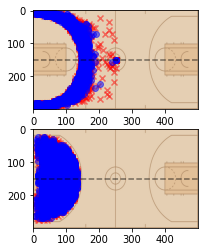

In [11]:
fig, ax = plt.subplots(2)

## def. 3pt
df_3pt = df_valid[
    np.logical_and(
        df_valid.shot_distance.map(lambda a: -1 if a == '' else int(a)) > 22, ## have distance, > 22
        df_valid.is_3pt,
    )
]

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_3pt)

ax[0].scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax[0].scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax[0].axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax[0].imshow(full_court_img)

## def. 2pt
df_2pt = df_valid[
    np.logical_and(
        df_valid.shot_distance.map(lambda a: 50 if a == '' else int(a)) < 22, ## have distance, > 22
        ~df_valid.is_3pt,
    )
]

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_2pt)

ax[1].scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax[1].scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax[1].axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax[1].imshow(full_court_img)

plt.show()

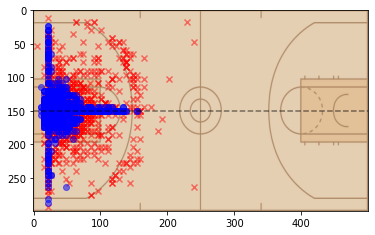

In [12]:
fig, ax = plt.subplots()

df_unlabeled = df_valid[
    np.logical_and(
        df_valid.shot_distance.str.len() == 0,
        ~df_valid.is_3pt,
    )
].copy()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_unlabeled)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax.imshow(full_court_img)

plt.show()

In [13]:
df_training = pd.concat([
    df_3pt[['single_location', 'is_3pt']],
    df_2pt[['single_location', 'is_3pt']]
]).sample(frac=1)

X = df_training.single_location.tolist()
y = df_training.is_3pt.astype(int).tolist()

model = SVC(random_state=42)
model.fit(X, y)

model.score(X, y)

0.9992567358315267

In [14]:
df_unlabeled['predicted_3pt'] = model.predict(df_unlabeled.single_location.tolist())
df_unlabeled.is_3pt = df_unlabeled.predicted_3pt.astype(bool)

print(len(df_unlabeled[df_unlabeled.is_3pt]))

115


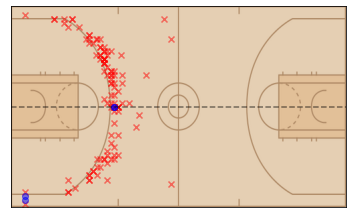

In [15]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(
    df_unlabeled[df_unlabeled.is_3pt]
)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

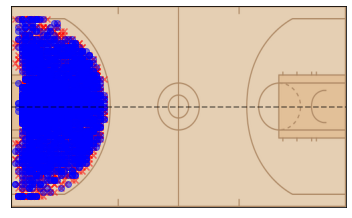

In [16]:
for index, row in df_valid.iterrows():
    if row['shot_distance'] == '' and not row['is_3pt']:
        df_valid.loc[df_valid.index == index, 'is_3pt'] = bool(model.predict([row['single_location']])[0])

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_valid[~df_valid['is_3pt']])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

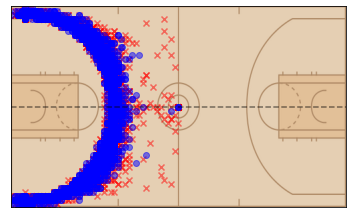

In [17]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_valid[df_valid['is_3pt']])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')
ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

### View Player Shot Charts

In [18]:
player = 'Kelsey Plum' ## 'Sylvia Fowles'
df_player = df_valid[df_valid.shot_by == player]

df_player.head()

,game_id,description,location,made,shot_by,shot_distance,shot_distance_cat,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court
1119,401391696,Kelsey Plum makes driving layup,"[48.0, 5.32]",True,Kelsey Plum,,,,layup,,False,True,left,"[48.0, 5.32]",left
1130,401391696,Kelsey Plum makes driving layup,"[48.0, 4.26]",True,Kelsey Plum,,,,layup,,False,True,left,"[48.0, 4.26]",left
1132,401391696,Kelsey Plum makes 25-foot three pointer (Jacki...,"[40.0, 29.79]",True,Kelsey Plum,25,+22 footer,,set,Jackie Young,True,True,left,"[40.0, 29.79]",left
1134,401391696,Kelsey Plum makes 24-foot step back jumpshot (...,"[20.0, 24.47]",True,Kelsey Plum,24,+22 footer,,step back,Theresa Plaisance,True,True,left,"[20.0, 24.47]",left
1135,401391696,Kelsey Plum misses 24-foot step back jumpshot,"[70.0, 27.66]",False,Kelsey Plum,24,+22 footer,,step back,,True,True,left,"[70.0, 27.66]",right


## Full Shot Chart

In [19]:
def get_makes_and_misses_full_court(df):
    def get_coordinates(df):
        x = df.location.map(lambda a: a[1])
        y = df.location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


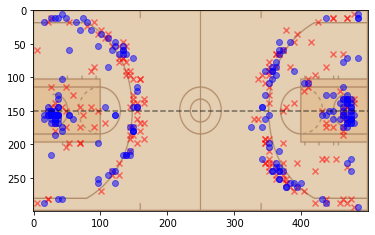

In [20]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_full_court(df_player)
ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

## y-axis flips, need to flip the y data...
ax.imshow(full_court_img)

plt.show()

## Half Shot Chart

In [21]:
def get_makes_and_misses_half_court(df):
    def get_coordinates(df):
        x = df.single_location.map(lambda a: a[1])
        y = df.single_location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


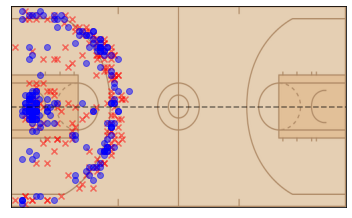

In [22]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

## How well did we pick up 3pt?

Kelsey Plum - shot chart


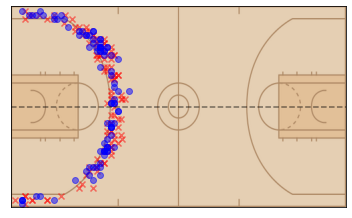

In [23]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player[df_player.is_3pt])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

In [24]:
df_player[df_player.is_3pt].groupby(['made', 'side_of_the_half_court']).count()[['game_id']]

game_id
made  side_of_the_half_court         
False left                         50
      right                        75
True  left                         39
      right                        53

In [25]:
df_agg_makes = df[np.logical_and(np.logical_and(df.shot_by == player, df.is_3pt), df.made)].groupby(['game_id']).count()[['made']]
df_agg_misses = df[np.logical_and(np.logical_and(df.shot_by == player, df.is_3pt), ~df.made)].groupby(['game_id']).count()[['made']]
df_agg_misses.columns = ['misses']

df_totals = df_agg_makes.join(df_agg_misses)
def format_3pt(row):
    made = row['made']
    miss = row['misses']
    total = made + miss

    return f'{made}-{total}'

df_totals['3PT'] = df_totals.apply(format_3pt, axis=1)

In [26]:
validation = pd.merge(
    df_boxscores.loc[df_boxscores.id == 3065570, ['game_id', '3PT']],
    df_totals,
    how="left",
    on='game_id'
)[['game_id', '3PT_x', '3PT_y']]

validation['is_correct'] = validation['3PT_x'] == validation['3PT_y']

validation

,game_id,3PT_x,3PT_y,is_correct
0,401391696,2-4,2-4,True
1,401391747,3-8,3-8,True
2,401391652,5-9,4-8,False
3,401391657,2-5,2-5,True
4,401391659,3-7,3-7,True
5,401391665,3-4,3-4,True
6,401391675,4-8,4-8,True
7,401391678,1-8,1-7,False
8,401391683,3-6,3-6,True
9,401391687,5-8,5-8,True


### Impute Shot Categories

In [27]:
df_shot_cat_1 = df_valid.loc[df_valid.shot_distance_cat == '0-5 footer']
df_shot_cat_2 = df_valid.loc[df_valid.shot_distance_cat == '<= 16 footer']
df_shot_cat_3 = df_valid.loc[df_valid.shot_distance_cat == '<= 22 footer']
df_shot_cat_4 = df_valid.loc[df_valid.shot_distance_cat == '+22 footer']

df_shot_cat_unlabeled = df_valid.loc[df_valid.shot_distance_cat == '']

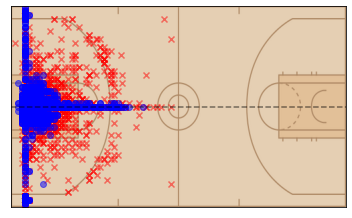

In [28]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_shot_cat_unlabeled)

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

df_training = pd.concat([
    df_shot_cat_1[['single_location', 'shot_distance_cat']],
    df_shot_cat_2[['single_location', 'shot_distance_cat']],
    df_shot_cat_3[['single_location', 'shot_distance_cat']],
    df_shot_cat_4[['single_location', 'shot_distance_cat']]
]).sample(frac=1)

X = df_training.single_location.tolist()

le = LabelEncoder()
le.fit(df_training.shot_distance_cat)

y = le.transform(df_training.shot_distance_cat)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

rf_model.score(X, y)

0.9871262965222697

In [31]:
indexes = []
input_data = []

for index, row in df_valid.iterrows():
    if row['shot_distance_cat'] == '':
        indexes.append(index)
        input_data.append(row['single_location'])

inferences = le.inverse_transform(rf_model.predict([row['single_location']]))

for index, inference in zip(indexes, inferences):
    df_valid.loc[df_valid.index == index, 'shot_distance_cat'] = inference

31288 0-5 footer


In [ ]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_valid.loc[df_valid.shot_distance_cat == '0-5 footer'])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_valid.loc[df_valid.shot_distance_cat == '<= 16 footer'])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_valid.loc[df_valid.shot_distance_cat == '<= 22 footer'])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
fig, ax = plt.subplots()

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_valid.loc[df_valid.shot_distance_cat == '+22 footer'])

ax.scatter(x_missed * x_scale, (100 - y_missed) * y_scale, marker='x', c='red', alpha=.5)
ax.scatter(x_make * x_scale, (100 - y_make) * y_scale, marker='o', c='blue', alpha=.5)
ax.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])
plt.show()

### parsed data

In [ ]:
## shot type
df.shot_type.unique()

In [ ]:
## shot type
df.shot_distance_cat.unique()

In [ ]:
## shots
sorted(df.shot_by.unique(), key=len, reverse=True)[:5]

In [ ]:
## blocks
sorted(df.blocked_by.unique(), key=len, reverse=True)[:5]

In [ ]:
## assists
sorted(df.assist_by.unique(), key=len, reverse=True)[:5]

In [ ]:
## shot distances

## 91.86 ft ..., -1 == 'Not Given'
sorted(list(map(lambda a: -1 if a == '' else int(a), df.shot_distance.unique())))[:5]